In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Input
import tensorflow as tf
from tqdm import tqdm
from IPython.display import clear_output

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
def update_board(board_temp,color,column):
    
    board = board_temp.copy()
    ncol = board.shape[1]
    nrow = board.shape[0]
    if column < ncol:
        row = -1
        for check in range(nrow):
            if board[check,column]!=0:
                break 
            else: 
                row += 1

        if row >= 0: 
            if color == 'plus': 
                board[row,column] = 1
            else:
                board[row,column] = -1
        return board
    else:
        column -= ncol
        if column >= ncol:
            return board 
        board[1:,column] = board[:-1,column].copy()
        board[0, column] = 0
        return board

In [5]:
def check_illegal_move(move, player, board):
    flag = False
    # OVERFLOW CONDITION
    if move in list(range(7)):
        # print(f'OVERFLOW CHECK: {board[5, move]}')
        if board[0, move] != 0:
            flag = True
    
    # UNDERFLOW CONDITION
    if move in list(range(7, 14)):
        if board[5, move-7] == 0:
            flag = True
        elif player=='plus' and board[5, move-7] == -1:
            flag = True
        elif player=='minus' and board[5, move-7] == 1:
            flag = True
    return flag

In [6]:
def check_for_win(board):
    # this function checks to see if anyone has won on the given board
    nrow = board.shape[0]
    ncol = board.shape[1]
    winner = 'nobody'
    for row in range(nrow):
        for col in range(ncol):
            # check for vertical winners
            if row <= (nrow-4): # can't have a column go from rows 4-7...
                if np.sum(board[row:(row+4),col])==4:
                    winner = 'v-plus'
                    return winner
                elif np.sum(board[row:(row+4),col])==-4:
                    winner = 'v-minus'
                    return winner
            # check for horizontal winners
            if col <= (ncol-4):
                if np.sum(board[row,col:(col+4)])==4:
                    winner = 'h-plus'
                    return winner
                elif np.sum(board[row,col:(col+4)])==-4:
                    winner = 'h-minus'
                    return winner
            # check for top left to bottom right diagonal winners
            if (row <= (nrow-4)) and (col <= (ncol-4)):
                if np.sum(board[range(row,row+4),range(col,col+4)])==4:
                    winner = 'd-plus'
                    return winner
                elif np.sum(board[range(row,row+4),range(col,col+4)])==-4:
                    winner = 'd-minus'
                    return winner
            # check for top right to bottom left diagonal winners
            if (row <= (nrow-4)) and (col >= 3):
                if np.sum(board[range(row,row+4),range(col,col-4,-1)])==4:
                    winner = 'd-plus'
                    return winner
                elif np.sum(board[range(row,row+4),range(col,col-4,-1)])==-4:
                    winner = 'd-minus'
                    return winner
    return winner

In [7]:
def display_board(board):
    # this function displays the board as ascii using X for +1 and O for -1
    clear_output()
    horizontal_line = '-'*(7*5+8)
    blank_line = '|'+' '*5
    blank_line *= 7
    blank_line += '|'
    print(horizontal_line)
    for row in range(6):
        print(blank_line)
        this_line = '|'
        for col in range(7):
            if board[row,col] == 0:
                this_line += ' '*5 + '|'
            elif board[row,col] == 1:
                this_line += '  X  |'
            else:
                this_line += '  O  |'
        print(this_line)
        print(blank_line)
        print(horizontal_line)     

In [8]:
def discount_rewards(r):
        
    delt = 0.99**4 # discount factor
    nr = len(r)
    # we want to change all those zeros into discounted values of the next reward (this is the value function!)
    discounted_r = [0.0]*nr
    
    for t in range(nr):
        # start at the end
        if r[nr-t-1] > 0: # if you won a point in this frame we want a good reward
            discounted_r[nr-t-1] = 1
        elif r[nr-t-1] < 0: # if we lost the point we want a bad reward
            discounted_r[nr-t-1] = -1
        elif t==0: # this is just for error catching...at t==0 r[nr-t-1] should have already been + or -...
            discounted_r[nr-t-1] = 0
        elif discounted_r[nr-t-1] == 0: # otherwise you want to look at the next reward value and discount it
            discounted_r[nr-t-1] = delt*discounted_r[nr-t]
    return discounted_r

In [9]:
def create_model_player(height, width):
    
    imp = Input(shape=(height, width, 1))
    mid = Conv2D(16, (2, 2), strides=1, activation='relu')(imp)
    mid = Flatten()(mid)
    mid = Dense(256, activation='relu')(mid)
    mid = Dense(64, activation='relu')(mid)
    mid = Dense(32, activation='relu')(mid)
    out0 = Dense(14, activation='softmax')(mid)
    model = Model(imp, out0)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6), loss='sparse_categorical_crossentropy')
    
    return model

In [10]:
def create_model_opp(height, width):
    
    imp = Input(shape=(height, width, 1))
    mid = Conv2D(16, (2, 2), strides=1, activation='relu')(imp)
    mid = Flatten()(mid)
    mid = Dense(256, activation='relu')(mid)
    mid = Dense(64, activation='relu')(mid)
    mid = Dense(32, activation='relu')(mid)
    out0 = Dense(14, activation='softmax')(mid)
    model = Model(imp, out0)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6), loss='sparse_categorical_crossentropy')
    
    return model

In [11]:
mod = create_model_player(6, 7)
mod.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6, 7, 1)]         0         
                                                                 
 conv2d (Conv2D)             (None, 5, 6, 16)          80        
                                                                 
 flatten (Flatten)           (None, 480)               0         
                                                                 
 dense (Dense)               (None, 256)               123136    
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 14)                462   

In [12]:
mod = create_model_opp(6, 7)
mod.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 6, 7, 1)]         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 5, 6, 16)          80        
                                                                 
 flatten_1 (Flatten)         (None, 480)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               123136    
                                                                 
 dense_5 (Dense)             (None, 64)                16448     
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 14)                462 

In [13]:
def play1game(model1, model2, random=False, display=False):

    plus_action_array = []
    minus_action_array = []
    plus_frame_array = []
    minus_frame_array = []
    plus_reward_array = []
    minus_reward_array = []
    winners = []

    board = np.zeros((6, 7))
    board_new = np.expand_dims(board.reshape((6, 7, 1)), axis=0)
    winner = 'nobody'
    player = 'plus'
    while winner == 'nobody':

        if player == 'plus':
            vf = model1(board_new, training=False).numpy()[0]
            if random==False:
                while True:
                    move = np.random.choice(14, p=vf)
                    if check_illegal_move(move, player, board) == False:
                        break
            else:
                move = np.argmax(vf*np.array([not check_illegal_move(i, player, board) for i in range(14)])) 
                # print(f"Best move is {move}")         
                
            plus_action_array.append(move)
            # print(plus_action_array)
            plus_frame_array.append(board.copy())
            plus_reward_array.append(0)
            board = update_board(board, player, move)
            player = 'minus'
        else:
            vf = model2(board_new, training=False).numpy()[0]
            if random==False:
                while True:
                    move = np.random.choice(14, p=vf)
                    if check_illegal_move(move, player, board) == False:
                       break
            else:
                while True:
                    move = np.random.choice(14)
                    if check_illegal_move(move, player, board) == False:
                        break
            minus_action_array.append(move)
            minus_frame_array.append(board.copy())
            minus_reward_array.append(0)
            board = update_board(board, player, move)
            player = 'plus'
    
        if display==True:
            print(board)
            print(f"VF is {vf}")
            time.sleep(3)
            
        winner = check_for_win(board)
        winners.append(winner)

    if winner.split('-')[1]=='plus':
        plus_reward_array[-1] = 1
    else:
        minus_reward_array[-1] = 1
    
    return plus_action_array, minus_action_array, plus_frame_array, minus_frame_array, plus_reward_array, minus_reward_array, winners

In [14]:
ngames = 5000
nbatch = 30
buffn = 10000
warmupgames = 50
len_buff_plus = 0
len_buff_minus = 0
buffer_plus = {'actions':[], 'rewards':[], 'frames':[]}
buffer_minus = {'actions':[], 'rewards':[], 'frames':[]}
mod1 = create_model_player(6, 7)
mod1.call = tf.function(mod1.call, experimental_relax_shapes=True)
mod2 = create_model_opp(6, 7)
mod2.call = tf.function(mod2.call, experimental_relax_shapes=True)

In [15]:
jeets = []
for game in range(ngames):

    start = time.time()
    plus_actions, minus_actions, plus_frames, minus_frames, plus_rewards, minus_rewards, winners = play1game(mod1, mod2)
    jeets += winners
    
    # print(f"plus rewards {plus_frames}")
    # print(f"minus rewards {minus_frames}")
    plus_rewards = discount_rewards(plus_rewards.copy())
    minus_rewards = discount_rewards(minus_rewards.copy())

    buffer_plus['actions'] += plus_actions.copy()
    buffer_plus['rewards'] += plus_rewards.copy()
    buffer_plus['frames'] += plus_frames.copy()
    
    buffer_minus['actions'] += minus_actions.copy()
    buffer_minus['rewards'] += minus_rewards.copy()
    buffer_minus['frames'] += minus_frames.copy()

    buffer_plus['actions'] = buffer_plus['actions'][-buffn:].copy() if len(buffer_plus['actions'])>buffn else buffer_plus['actions']
    buffer_plus['rewards'] = buffer_plus['rewards'][-buffn:].copy() if len(buffer_plus['rewards'])>buffn else buffer_plus['rewards']
    buffer_plus['frames'] = buffer_plus['frames'][-buffn:].copy() if len(buffer_plus['frames'])>buffn else buffer_plus['frames']
    len_buff_plus = len(buffer_plus['frames'])

    buffer_minus['actions'] = buffer_minus['actions'][-buffn:].copy() if len(buffer_minus['actions'])>buffn else buffer_minus['actions']
    buffer_minus['rewards'] = buffer_minus['rewards'][-buffn:].copy() if len(buffer_minus['rewards'])>buffn else buffer_minus['rewards']
    buffer_minus['frames'] = buffer_minus['frames'][-buffn:].copy() if len(buffer_minus['frames'])>buffn else buffer_minus['frames']
    len_buff_minus = len(buffer_minus['frames'])  

    if game >= warmupgames:
        prob_plus = np.ones(len(buffer_plus['frames']))
        prob_plus[np.array(buffer_plus['rewards']) > 0] = 5.0
        prob_plus /= np.sum(prob_plus)
        # print(f'Probs plus {prob_plus}')
        inds_plus = np.random.choice(len(buffer_plus['frames']), size=nbatch, replace=False, p=prob_plus)

        prob_minus = np.ones(len(buffer_minus['frames']))
        prob_minus[np.array(buffer_minus['rewards']) > 0] = 5.0
        prob_minus /= np.sum(prob_minus)
        inds_minus = np.random.choice(len(buffer_minus['frames']), size=nbatch, replace=False, p=prob_minus)


        buffer_plus_rewards = np.array([buffer_plus['rewards'][ind] for ind in inds_plus])
        buffer_plus_actions = np.array([buffer_plus['actions'][ind] for ind in inds_plus])
        buffer_plus_frames = np.array([buffer_plus['frames'][ind] for ind in inds_plus])

        mod1.fit(buffer_plus_frames, buffer_plus_actions, epochs=1, batch_size=nbatch, verbose=0, sample_weight=buffer_plus_rewards)


        buffer_minus_rewards = np.array([buffer_minus['rewards'][ind] for ind in inds_minus])
        buffer_minus_actions = np.array([buffer_minus['actions'][ind] for ind in inds_minus])
        buffer_minus_frames = np.array([buffer_minus['frames'][ind] for ind in inds_minus])

        mod2.fit(buffer_minus_frames, buffer_minus_actions, epochs=1, batch_size=nbatch, verbose=0, sample_weight=buffer_minus_rewards)

    stop = time.time()
    print(game, plus_rewards[-1], stop-start, len_buff_plus, len_buff_minus)

0 0 3.8359766006469727 33 33
1 1 0.05691933631896973 39 39
2 1 0.07845497131347656 48 47
3 0 0.07231950759887695 56 54
4 0 0.12490248680114746 69 67
5 0 0.06876349449157715 77 75
6 0 0.1305854320526123 92 90
7 0 0.04047369956970215 97 94
8 1 0.0879061222076416 107 103
9 1 0.04089713096618652 112 107
10 1 0.28844285011291504 145 139
11 1 0.04089093208312988 150 143
12 0 0.1003103256225586 161 154
13 0 0.040924787521362305 166 159
14 0 0.2316896915435791 192 185
15 0 0.08065104484558105 201 194
16 1 0.10863327980041504 214 206
17 1 0.19046401977539062 236 227
18 1 0.153900146484375 254 244
19 1 0.0619206428527832 262 251
20 0 0.13351798057556152 277 266
21 1 0.06536316871643066 285 273
22 1 0.08815789222717285 295 282
23 0 0.0498807430267334 301 287
24 0 0.10947632789611816 310 296
25 0 0.1434004306793213 322 308
26 1 0.14212369918823242 336 321
27 0 0.06736445426940918 343 328
28 1 0.07639169692993164 351 335
29 1 0.09977316856384277 362 345
30 1 0.15419507026672363 378 360
31 1 0.16162

In [32]:
wins=[]
for i in tqdm(range(300)):
    plus_action_array, minus_action_array, plus_frame_array, minus_frame_array, plus_reward_array, minus_reward_array, winners = play1game(mod1, mod2, random=True, display=False)
    wins.append(plus_reward_array[-1])

100%|██████████| 300/300 [00:08<00:00, 34.97it/s]


In [33]:
print(f"Win rate against random opponent is {np.array(wins).mean()*100}%")

Win rate against random opponent is 99.0%


In [34]:
mod1.save('popout.h5')

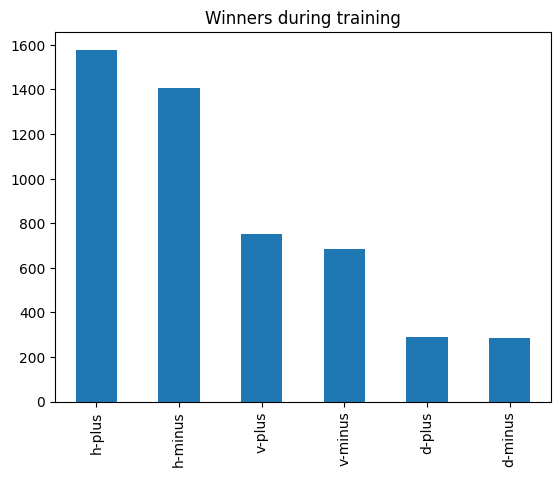

In [ ]:
pd.Series(jeets).value_counts().drop('nobody').plot(kind='bar')
plt.title('Winners during training')
plt.show()

Text(0.5, 1.0, 'Types of wins during training')

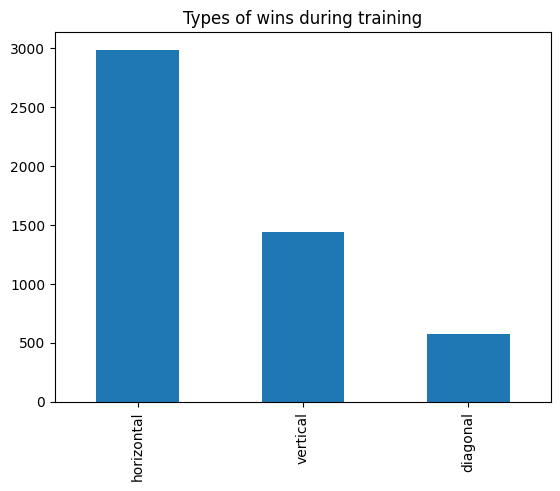

In [ ]:
pd.Series(jeets).map(lambda x: x.split('-')[0] if x!='nobody' else 'nobody').value_counts().drop('nobody').rename({
    'h': 'horizontal',
    'v': 'vertical',
    'd': 'diagonal'
}).plot(kind='bar')

plt.title('Types of wins during training')
plt.show()

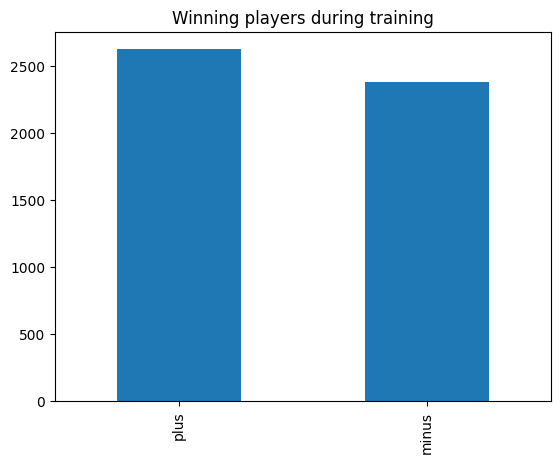

In [ ]:
pd.Series(jeets).map(lambda x: x.split('-')[1] if x!='nobody' else 'nobody').value_counts().drop('nobody').plot(kind='bar')

plt.title('Winning players during training')
plt.show()